## Table of Contents
- [1. Loading data](#loading-data)
- [2. Data inspection and label extraction](#data-inspection-and-label-extraction)
- [3. Identifying the best rolling window size](#identifying-the-best-rolling-window-size)
- [4. Removing trends and find similarity between replicates](#removing-trends-and-find-similarity-between-replicates)
- [5. Calculating similarity score between series](#calculating-similarity-score-between-series)
- [6. Feature extraction](#feature-extraction)
- [7. PCA and UMAP](#pca-and-umap)
- [8. Identifying the most influential features](#identifying-the-most-influential-features)
- [9. Classification model](#classification-model)


### 1. Loading data <d id="loading-data">


In [6]:
# Importing necessary libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation and analysis
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC

# Statistical and signal processing
from scipy.signal import detrend, correlate, find_peaks
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
from statsmodels.tsa.stattools import acf
import pywt
from scipy.spatial.distance import euclidean
from numpy.polynomial.polynomial import Polynomial

# Dimensionality reduction and visualization
import umap

In [3]:
# Loading data from a .pkl file
with open('two_devices_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

### 2. Data inspection and label extraction <d id="data-inspection-and-label-extraction">

In [4]:
# get information about the dictionary
print("The type of the loaded data is: ", type(loaded_data))

# get the keys of the dictionary
print("The keys of the dictionary are: ", loaded_data.keys())

# print just first value of the dictionary in Backscat
print("The first value of the dictionary in Backscat is: ", loaded_data['Backscat'][0][0])

The type of the loaded data is:  <class 'dict'>
The keys of the dictionary are:  dict_keys(['Probe', 'Backscat', 'Date', 'Label'])
The first value of the dictionary in Backscat is:  [0.04249295 0.04219714 0.04211998 ... 0.04228717 0.04220357 0.04202352]


In [ ]:
# Exploring the date values
print(loaded_data['Date'][0][1]-loaded_data['Date'][0][0])

37896199


In [ ]:
# Convert the specified elements to lists
probe_list = [loaded_data['Probe'][i][0] for i in range(70)]
label_list = [loaded_data['Label'][i][0] for i in range(70)]

# Create a DataFrame from the lists
df = pd.DataFrame({
    'Probe': probe_list,
    'Label': label_list
})

# Display the DataFrame
print(df)

   Probe Label
0   OZ02    C3
1   OZ02    C4
2   OZ02    C1
3   OZ02    C6
4   OZ02    C7
..   ...   ...
65  OZ03    C3
66  OZ03    C1
67  OZ03    C5
68  OZ03    C2
69  OZ03    C7

[70 rows x 2 columns]


In [ ]:
# group by the prob and label and count the number of each group
df.groupby(['Probe', 'Label']).size().reset_index(name='Count')

,Probe,Label,Count
0,OZ02,C1,5
1,OZ02,C2,5
2,OZ02,C3,5
3,OZ02,C4,5
4,OZ02,C5,5
5,OZ02,C6,5
6,OZ02,C7,5
7,OZ03,C1,5
8,OZ03,C2,5
9,OZ03,C3,5


In [ ]:
# save values of the dictionary for key 'Probe' and 'Label' in a pandas dataframe
Labels = pd.DataFrame({'Probe': loaded_data['Probe'], 'Label': loaded_data['Label']})
# remove [''] from values of column 'Label' and 'Probe'
Labels['Label'] = Labels['Label'].str.replace("'", "")
Labels['Label'] = Labels['Label'].str.replace("[", "")
Labels['Label'] = Labels['Label'].str.replace("]", "")
Labels['Probe'] = Labels['Probe'].str.replace("'", "")
Labels['Probe'] = Labels['Probe'].str.replace("[", "")
Labels['Probe'] = Labels['Probe'].str.replace("]", "")

In [ ]:
# save the dataframe to a csv file
Labels.to_csv('data/Labels.csv', sep='\t', index=False)

### 3. Identifying the best rolling window size <d id="identifying-the-best-rolling-window-size">


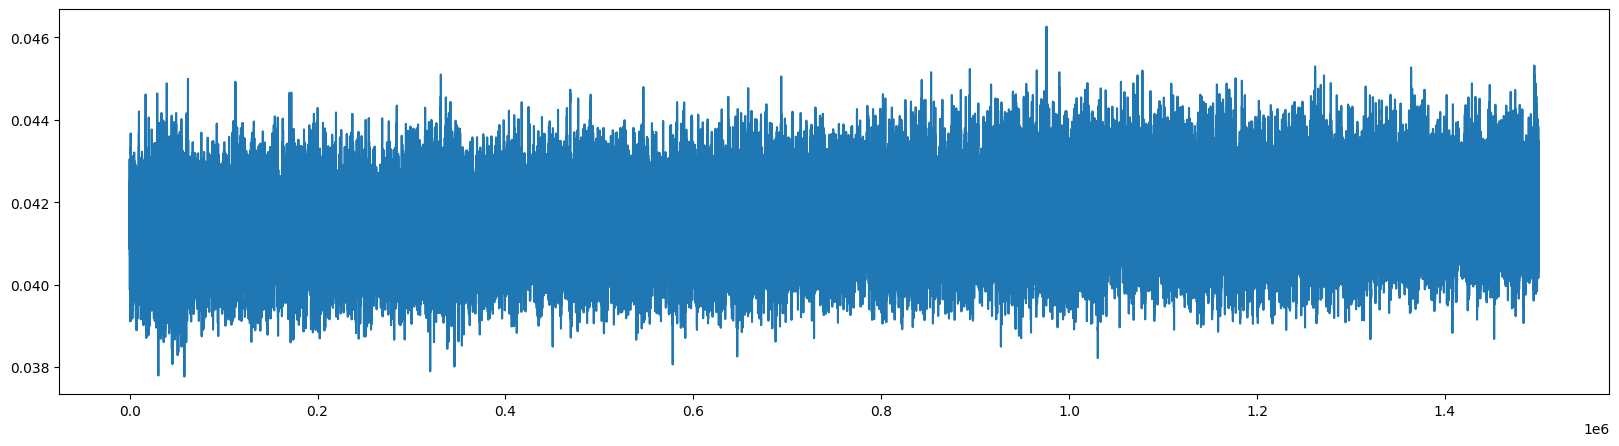

In [4]:
# visulaize the loaded_data['Backscat'][0][0]
plt.figure(figsize=(20, 5))
plt.plot(loaded_data['Backscat'][0][0])
plt.show()

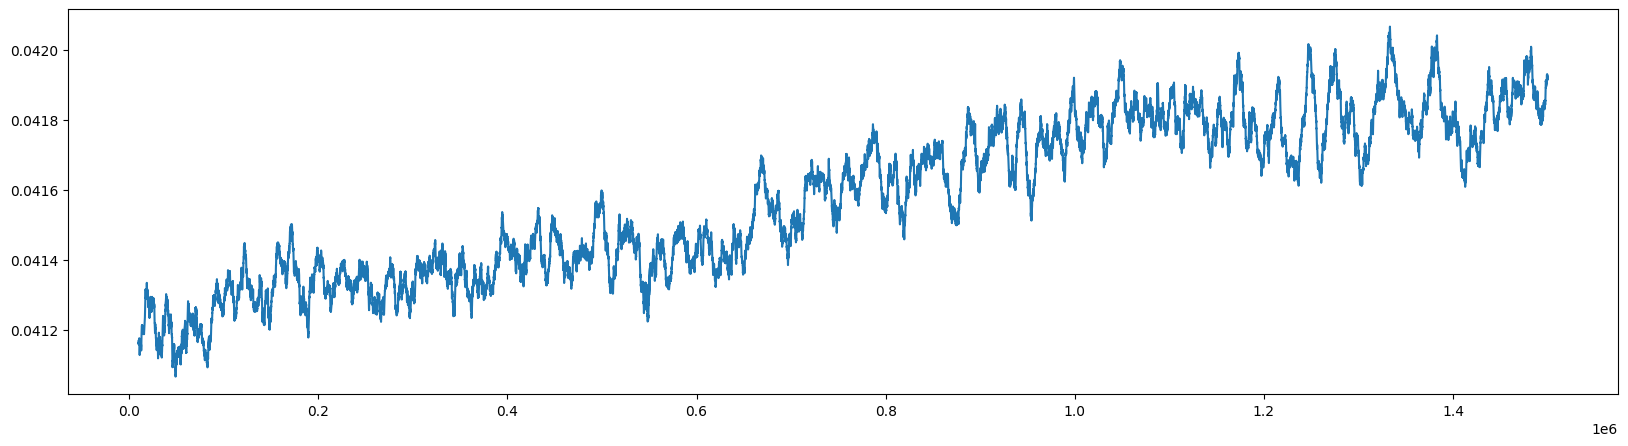

In [5]:
# rolling data by mean for each 10000 values and plot the result
plt.figure(figsize=(20, 5))
plt.plot(pd.Series(loaded_data['Backscat'][0][0]).rolling(window=10000).mean())
plt.show()

/Users/arahjou/Documents/Com_Conda/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


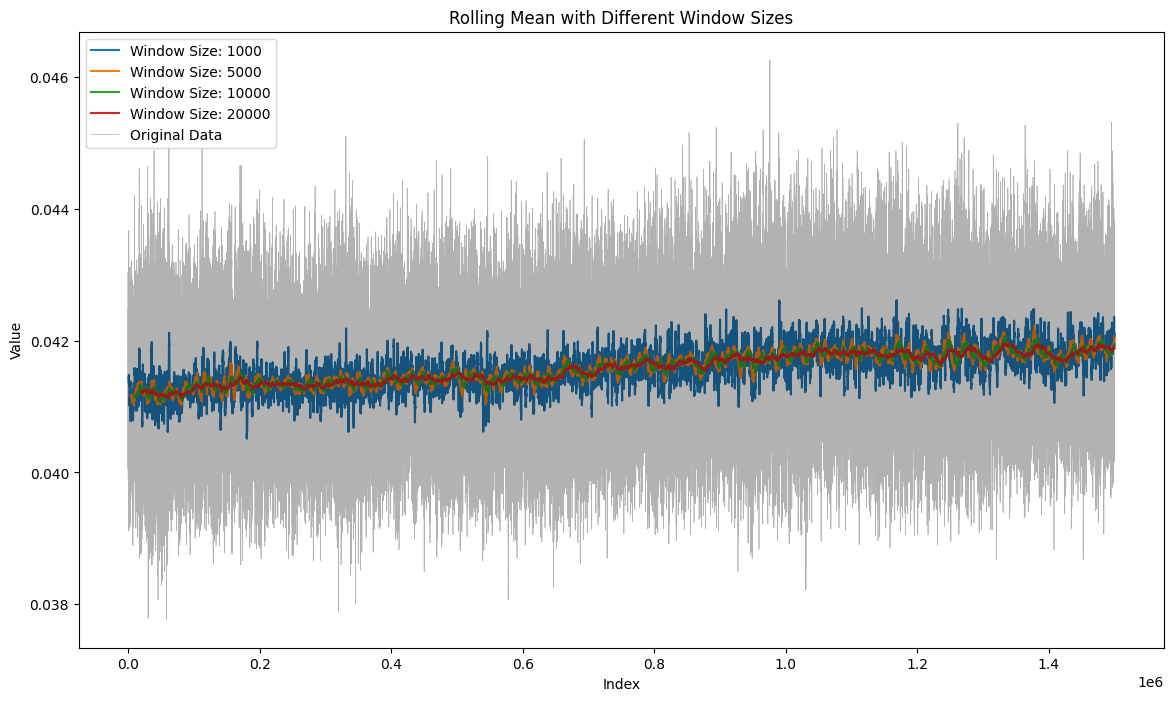

In [8]:
# Create a pandas Series from the loaded data
data_series = pd.Series(loaded_data['Backscat'][0][0])

# Function to plot rolling windows
def plot_rolling_windows(data, windows):
    plt.figure(figsize=(14, 8))
    for window in windows:
        smoothed = data.rolling(window=window).mean()
        plt.plot(smoothed, label=f'Window Size: {window}')
    plt.plot(data, label='Original Data', color='black', linewidth=0.5, alpha=0.3)
    plt.legend()
    plt.title('Rolling Mean with Different Window Sizes')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

# Example usage
windows = [1000, 5000, 10000, 20000]  # Different window sizes to test
plot_rolling_windows(data_series, windows)


In [9]:
def calculate_mse(original, smoothed):
    return ((original - smoothed) ** 2).mean()

def evaluate_windows(data, windows):
    mse_results = {}
    for window in windows:
        smoothed = data.rolling(window=window).mean()
        mse = calculate_mse(data, smoothed)
        mse_results[window] = mse
    return mse_results

# Example usage
windows = range(1000, 20001, 1000)  # Range of window sizes
mse_results = evaluate_windows(data_series, windows)

# Display results
for window, mse in mse_results.items():
    print(f'Window Size: {window}, MSE: {mse}')

Window Size: 1000, MSE: 6.049387070591134e-07
Window Size: 2000, MSE: 6.08263162893526e-07
Window Size: 3000, MSE: 6.087288085752031e-07
Window Size: 4000, MSE: 6.093712976412305e-07
Window Size: 5000, MSE: 6.09151184333115e-07
Window Size: 6000, MSE: 6.090751267352616e-07
Window Size: 7000, MSE: 6.09439623327463e-07
Window Size: 8000, MSE: 6.097924536960102e-07
Window Size: 9000, MSE: 6.100770175310084e-07
Window Size: 10000, MSE: 6.099180532893814e-07
Window Size: 11000, MSE: 6.100039688074623e-07
Window Size: 12000, MSE: 6.09928619719816e-07
Window Size: 13000, MSE: 6.101489764120493e-07
Window Size: 14000, MSE: 6.10181477165378e-07
Window Size: 15000, MSE: 6.100580819052962e-07
Window Size: 16000, MSE: 6.105110439421398e-07
Window Size: 17000, MSE: 6.099252289373103e-07
Window Size: 18000, MSE: 6.101461877610098e-07
Window Size: 19000, MSE: 6.099292989033577e-07
Window Size: 20000, MSE: 6.097276081483032e-07


**Note: This script is to determine the optimal window size for smoothing a time series dataset using a rolling average method. The goal is accomplished this by performing cross-validation on different window sizes and selecting the one that yields the lowest mean squared error (MSE).**

In [10]:
def cross_validate_windows(data, windows):
    tscv = TimeSeriesSplit(n_splits=5)
    best_window = None
    best_score = float('inf')
    
    for window in windows:
        scores = []
        for train_index, test_index in tscv.split(data):
            train, test = data[train_index], data[test_index]
            smoothed_train = train.rolling(window=window).mean().dropna()
            smoothed_test = test.rolling(window=window).mean().dropna()
            score = calculate_mse(train[len(train) - len(smoothed_train):], smoothed_train)
            scores.append(score)
        avg_score = np.mean(scores)
        if avg_score < best_score:
            best_score = avg_score
            best_window = window
    
    return best_window, best_score

# Example usage
best_window, best_score = cross_validate_windows(data_series, windows)
print(f'Best Window Size: {best_window}, Best Score: {best_score}')

Best Window Size: 1000, Best Score: 5.892528394365831e-07


### 4. Removing trends and find similarity between replicates <d id="removing-trends-and-find-similarity-between-replicates">

In [11]:
# Determine number of values in each loaded_data['Backscat'][i][j]
[len(loaded_data['Backscat'][i][j]) for i in range(70) for j in range(5)]

[1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,
 1500000,


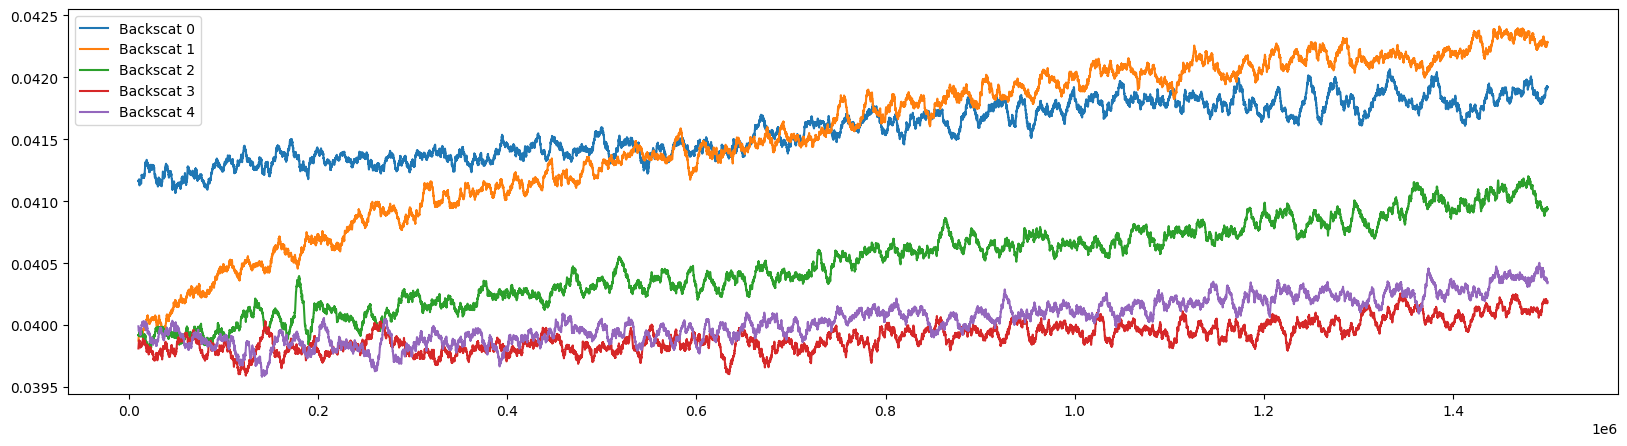

In [12]:
# Create a figure with a specified size
plt.figure(figsize=(20, 5))

# Loop through the specified range and plot each series with a rolling mean
for i in range(5):
    series = pd.Series(loaded_data['Backscat'][0][i])
    rolling_mean = series.rolling(window=10000).mean()
    plt.plot(rolling_mean, label=f'Backscat {i}')

# Add a legend to differentiate between the series
plt.legend()

# Display the plot
plt.show()


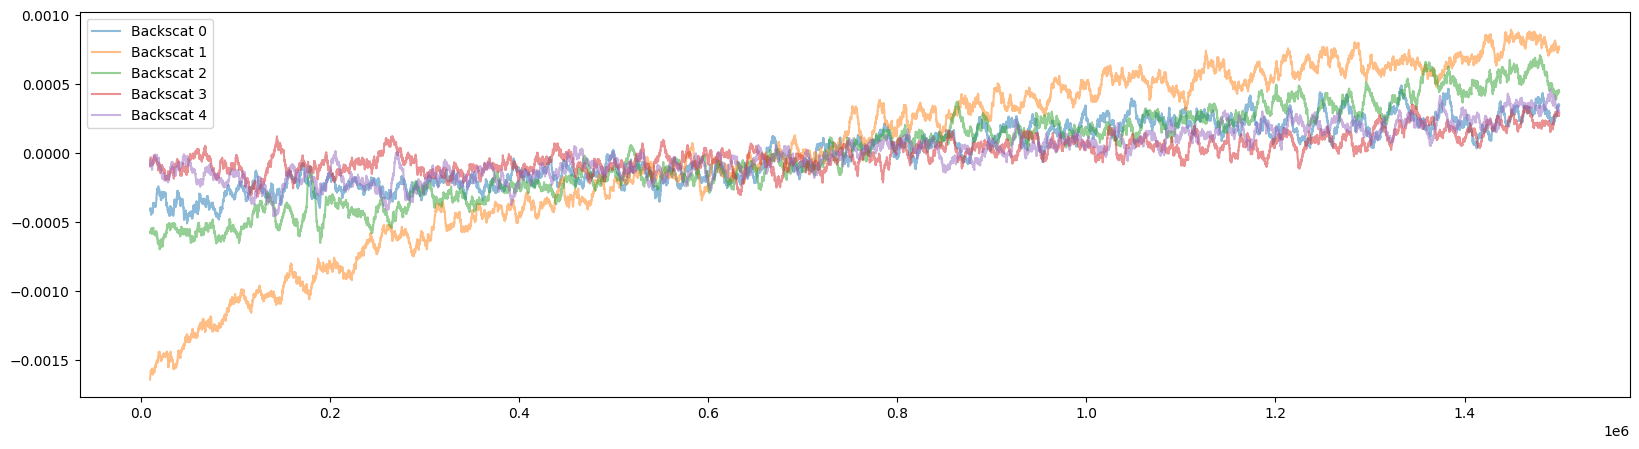

In [13]:
# Centering around the mean
# Create a figure with a specified size
plt.figure(figsize=(20, 5))

# Loop through the specified range and plot each series with a rolling mean
for i in range(5):
    series = pd.Series(loaded_data['Backscat'][0][i])
    
    # Mean centering
    series_centered = series - series.mean()
    
    # Calculate the rolling mean
    rolling_mean = series_centered.rolling(window=10000).mean()
    
    # Plot the rolling mean
    plt.plot(rolling_mean, label=f'Backscat {i}', alpha = 0.5)

# Add a legend to differentiate between the series
plt.legend()

# Display the plot
plt.show()

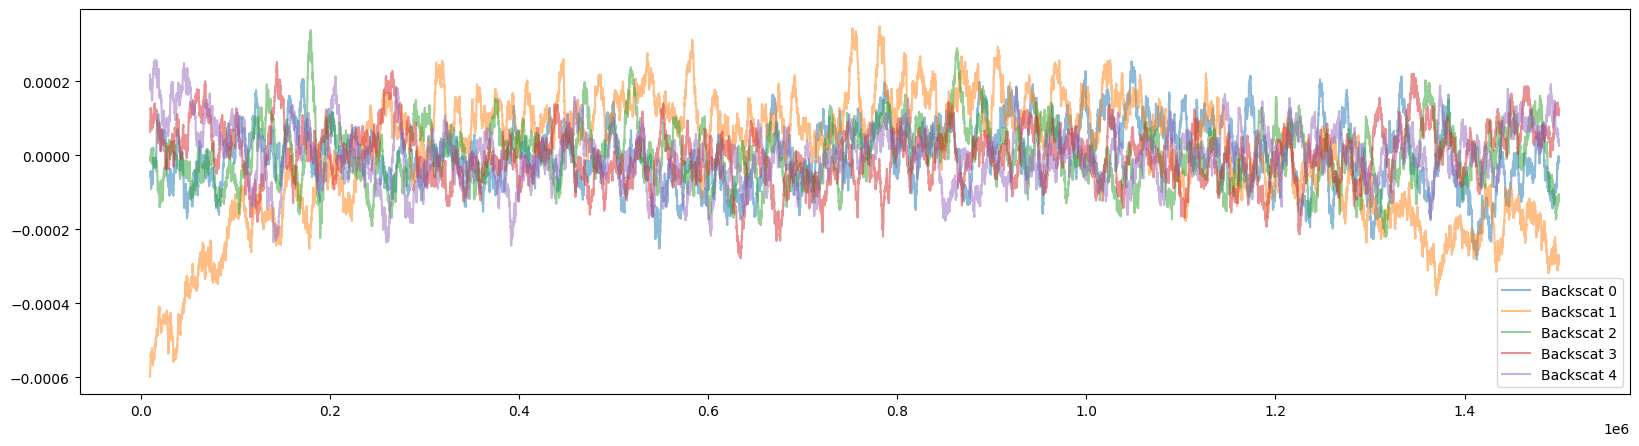

In [14]:
# Create a figure with a specified size
plt.figure(figsize=(20, 5))

# Loop through the specified range and plot each series with a rolling mean
for i in range(5):
    series = pd.Series(loaded_data['Backscat'][0][i])
    
    # Mean centering
    series_centered = series - series.mean()
    
    # Linear detrending
    series_detrended = detrend(series_centered)
    
    # Calculate the rolling mean
    rolling_mean = pd.Series(series_detrended).rolling(window=10000).mean()
    
    # Plot the rolling mean
    plt.plot(rolling_mean, label=f'Backscat {i}', alpha = 0.5)

# Add a legend to differentiate between the series
plt.legend()

# Display the plot
plt.show()


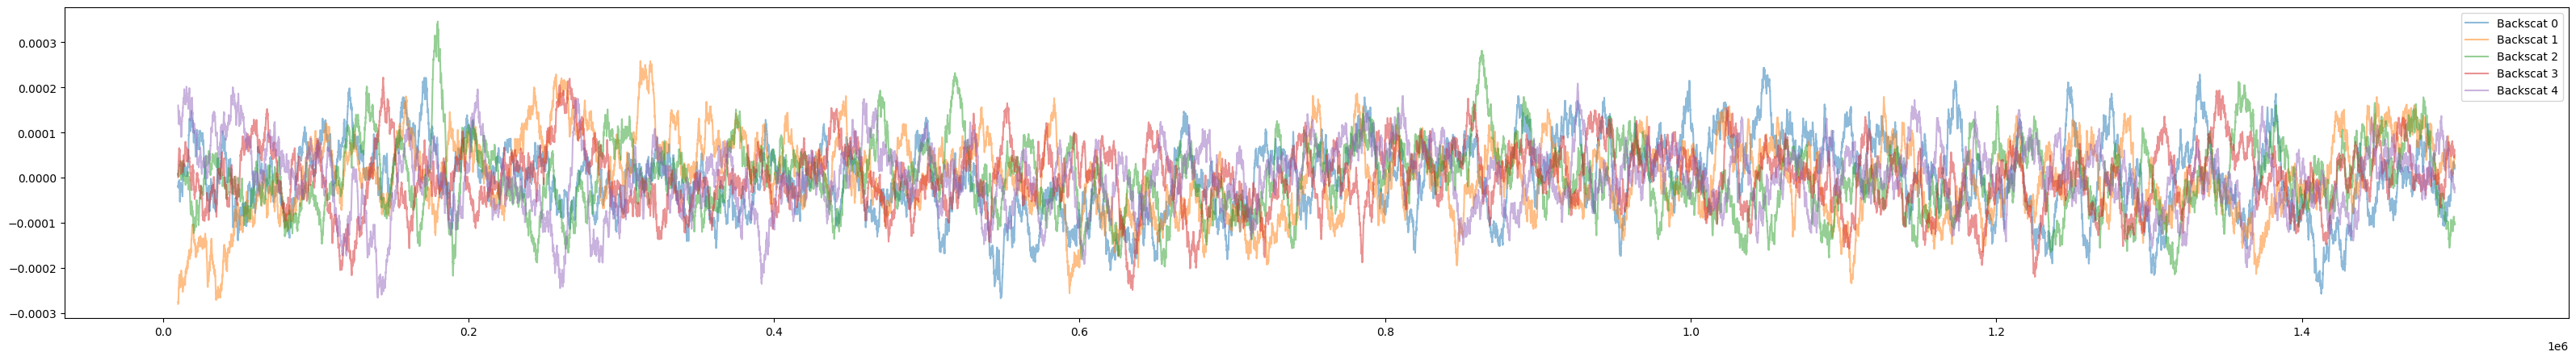

In [15]:
# Create a figure with a specified size
plt.figure(figsize=(40, 5))

# Loop through the specified range and plot each series with a rolling mean
for i in range(5):
    series = pd.Series(loaded_data['Backscat'][0][i])
    
    # Mean centering
    series_centered = series - series.mean()
    
    # Quadratic detrending
    x = np.arange(len(series_centered))
    p = Polynomial.fit(x, series_centered, 2)
    series_detrended = series_centered - p(x)
    
    # Calculate the rolling mean
    rolling_mean = pd.Series(series_detrended).rolling(window=10000).mean()
    
    # Plot the rolling mean
    plt.plot(rolling_mean, label=f'Backscat {i}', alpha = 0.5)

# Add a legend to differentiate between the series
plt.legend()

# Display the plot
plt.show()


### 5. calculating similarity score between series <d id="calculating-similarity-score-between-series">

Cross-correlation between Backscat 0 and Backscat 1:


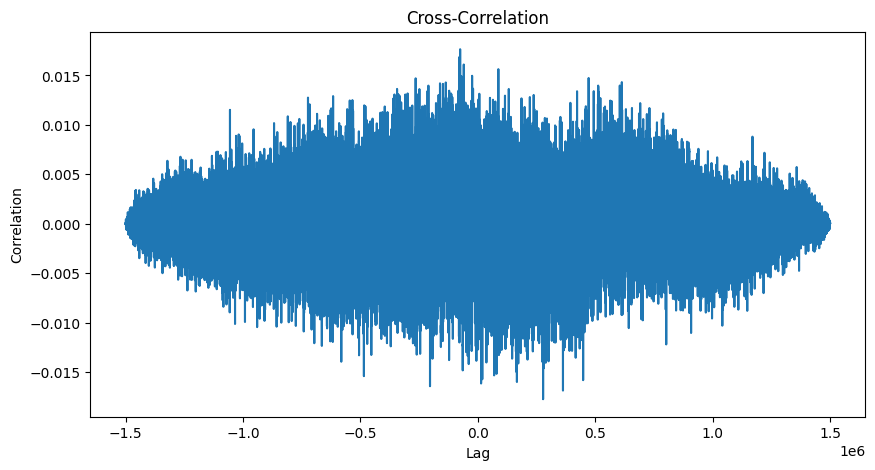

Cross-correlation between Backscat 0 and Backscat 2:


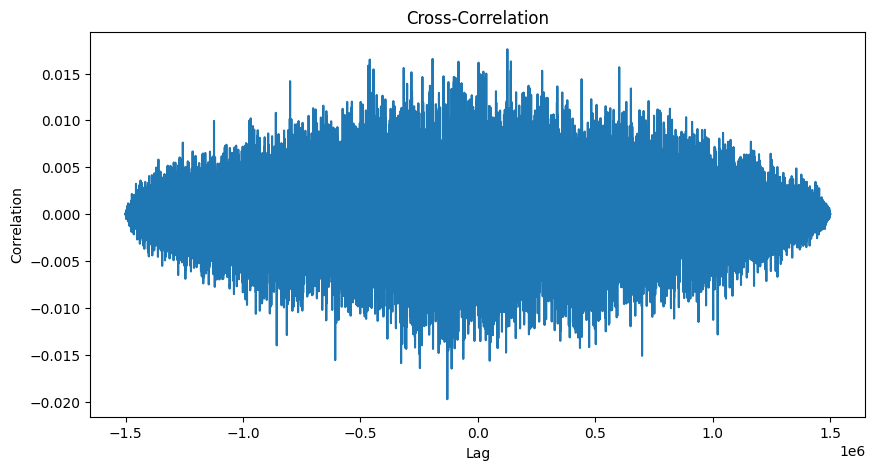

Cross-correlation between Backscat 0 and Backscat 3:


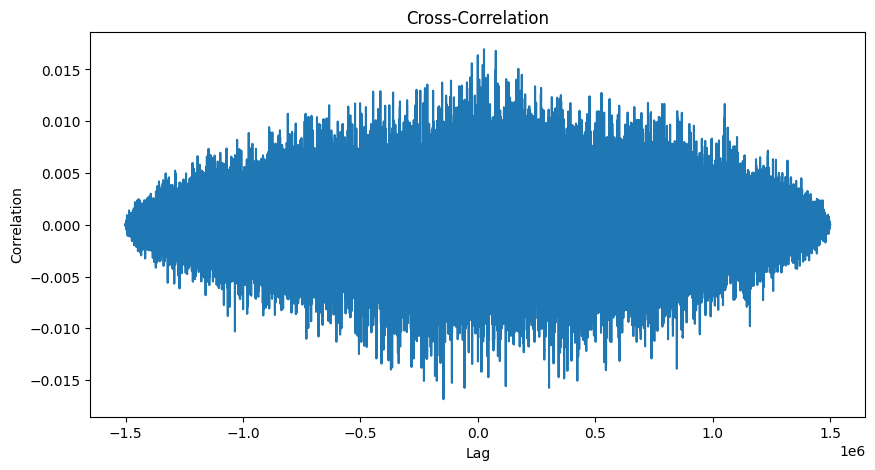

Cross-correlation between Backscat 0 and Backscat 4:


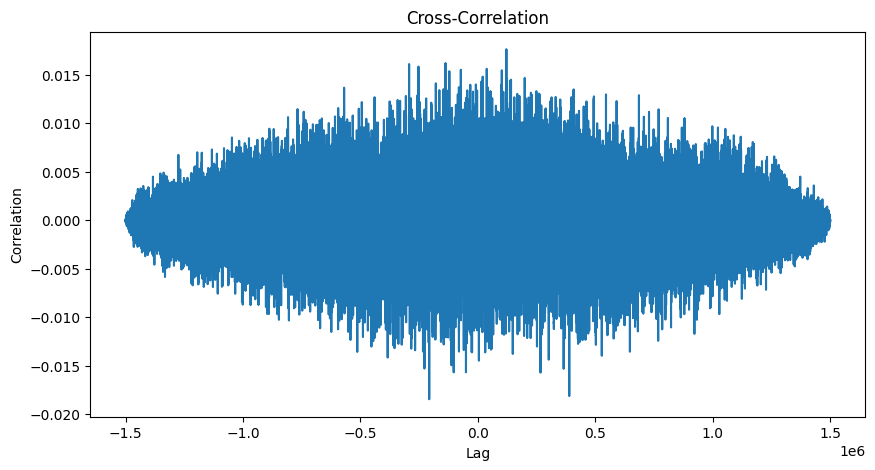

Cross-correlation between Backscat 1 and Backscat 2:


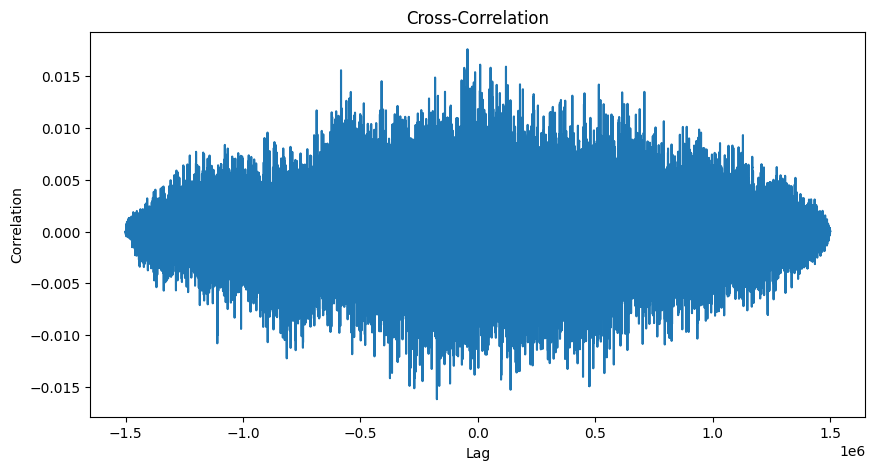

Cross-correlation between Backscat 1 and Backscat 3:


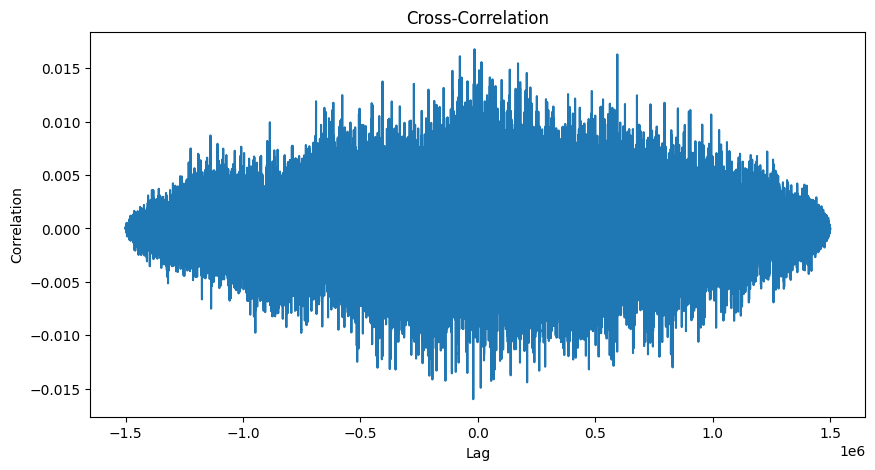

Cross-correlation between Backscat 1 and Backscat 4:


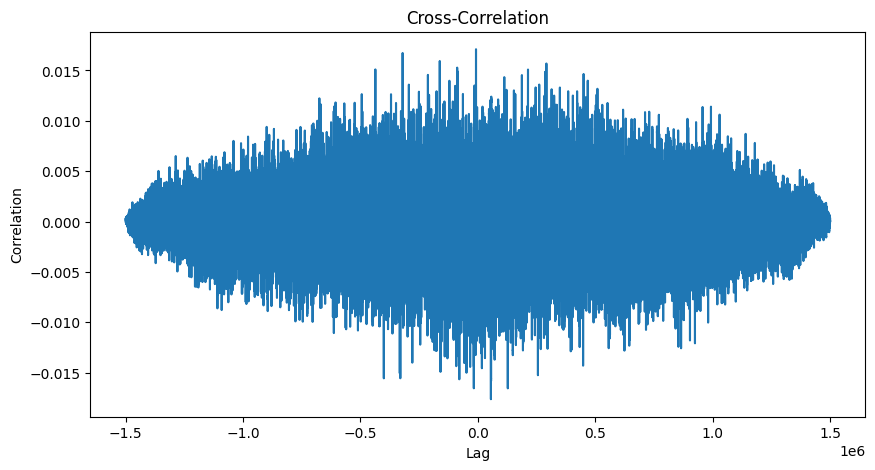

Cross-correlation between Backscat 2 and Backscat 3:


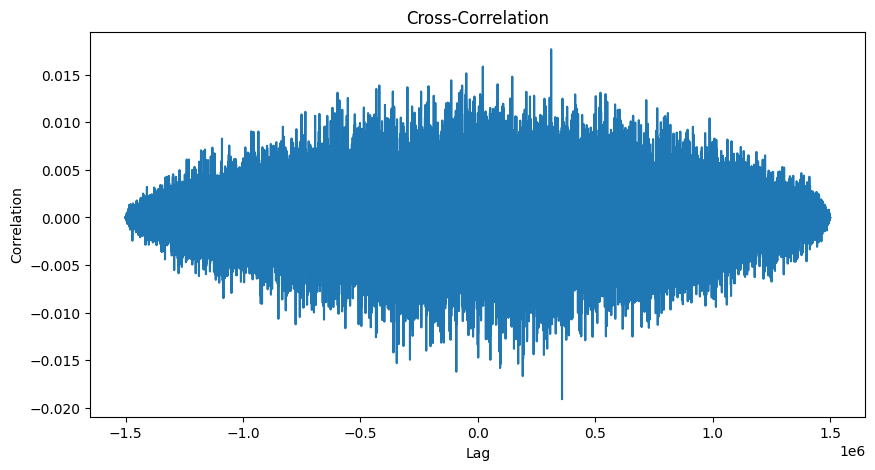

Cross-correlation between Backscat 2 and Backscat 4:


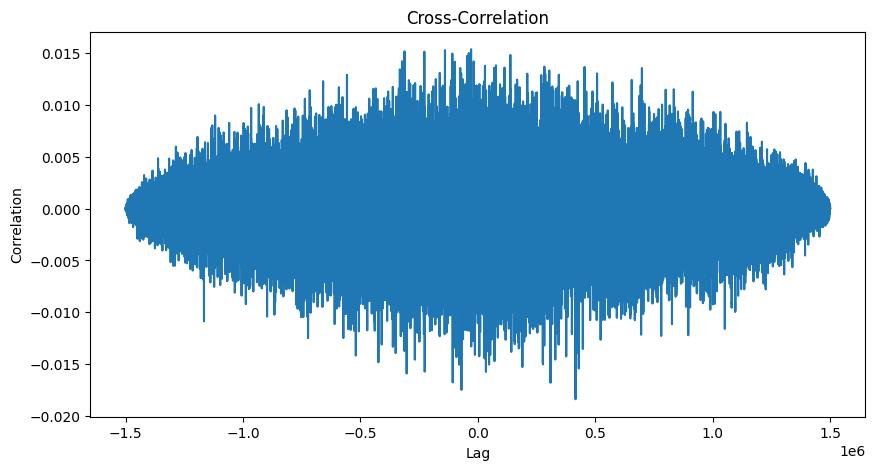

Cross-correlation between Backscat 3 and Backscat 4:


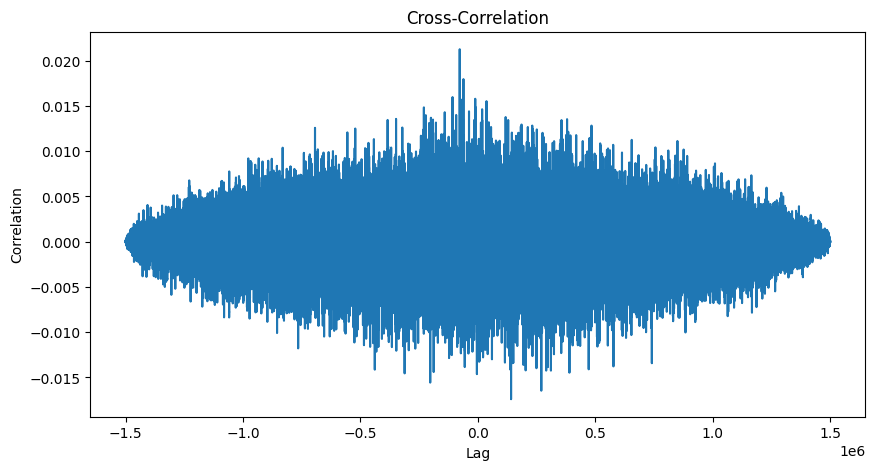

Pearson Correlation Coefficients:
 [[ 1.00000000e+00 -5.94630597e-03  1.03286440e-02  1.30291737e-02
  -3.65406148e-03]
 [-5.94630597e-03  1.00000000e+00  9.70792820e-04  2.60724529e-03
  -1.41885990e-03]
 [ 1.03286440e-02  9.70792820e-04  1.00000000e+00  1.67441998e-03
   1.15187452e-03]
 [ 1.30291737e-02  2.60724529e-03  1.67441998e-03  1.00000000e+00
  -4.52321255e-04]
 [-3.65406148e-03 -1.41885990e-03  1.15187452e-03 -4.52321255e-04
   1.00000000e+00]]


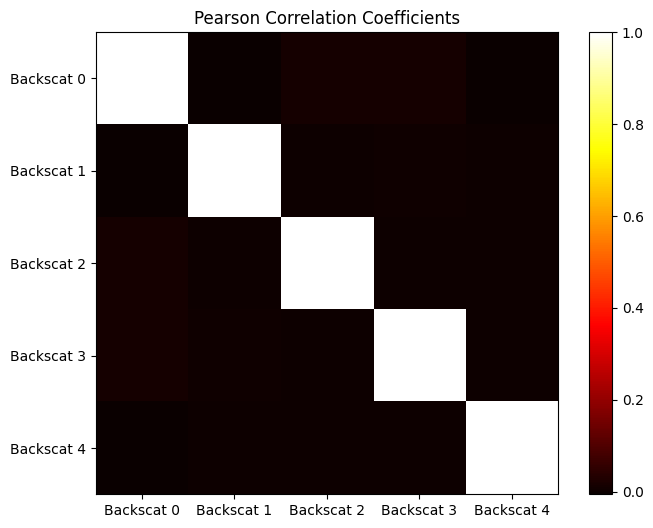

In [16]:
"""
This code snippet demonstrates how to compute and plot the cross-correlation between two time series.
1. Normalize the data by mean centering and detrending.
2. Removing the trend from the data by fitting a quadratic polynomial.
3. Computing the cross-correlation between each pair of series.
"""

# Prepare the data by detrending
detrended_data = []
for i in range(5):
    series = pd.Series(loaded_data['Backscat'][0][i])
    series_centered = series - series.mean()
    x = np.arange(len(series_centered))
    p = Polynomial.fit(x, series_centered, 2)
    series_detrended = series_centered - p(x)
    detrended_data.append(series_detrended)

# Function to compute and plot cross-correlation
def plot_cross_correlation(series1, series2, max_lag=500):
    corr = correlate(series1, series2, mode='full')
    lags = np.arange(-len(series1) + 1, len(series1))
    plt.figure(figsize=(10, 5))
    plt.plot(lags, corr)
    plt.title('Cross-Correlation')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.show()

# Compute and plot cross-correlation for each pair of series
for i in range(5):
    for j in range(i + 1, 5):
        print(f'Cross-correlation between Backscat {i} and Backscat {j}:')
        plot_cross_correlation(detrended_data[i], detrended_data[j])

# # Pearson correlation for entire series
# pearson_corr = np.corrcoef(detrended_data)
# print("Pearson Correlation Coefficients:\n", pearson_corr)

# # Heatmap of Pearson correlation coefficients
# plt.figure(figsize=(8, 6))
# plt.imshow(pearson_corr, cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.title('Pearson Correlation Coefficients')
# plt.xticks(range(5), [f'Backscat {i}' for i in range(5)])
# plt.yticks(range(5), [f'Backscat {i}' for i in range(5)])
# plt.show()


#### Concept Summary: Identifying Similar Regions Across Multiple Time Series

#### Objective
The goal is to find similar regions across five time series data sets. By analyzing and comparing these series, we can identify segments where the series exhibit high similarity.

#### Steps and Methodology

1. **Sliding Window Approach**
   - **Window Definition**: A fixed-size window is defined to segment the time series data into smaller, manageable pieces.
   - **Window Size**: In this example, a window size of 10,000 data points is used.

2. **Similarity Metric**
   - **Euclidean Distance**: For each window segment, the pairwise Euclidean distances between all five series are calculated.
   - **Sum of Pairwise Distances**: These distances are summed to obtain a similarity score for each window segment. Lower scores indicate higher similarity.

3. **Computing Similarity Scores**
   - **Sliding Window Calculation**: The window slides across the time series data, and similarity scores are computed for each window position.
   - **Storing Scores**: These scores are stored in a list for further analysis.

4. **Analysis and Visualization**
   - **Plotting Similarity Scores**: The similarity scores are plotted to visualize regions of high similarity across the series.
   - **Identifying Similar Regions**: Regions with the highest similarity (lowest distances) are identified using a threshold. In this example, the top 5% most similar regions are selected.

Note: Adjusting the window_size and threshold to fine-tune the detection of similar regions.

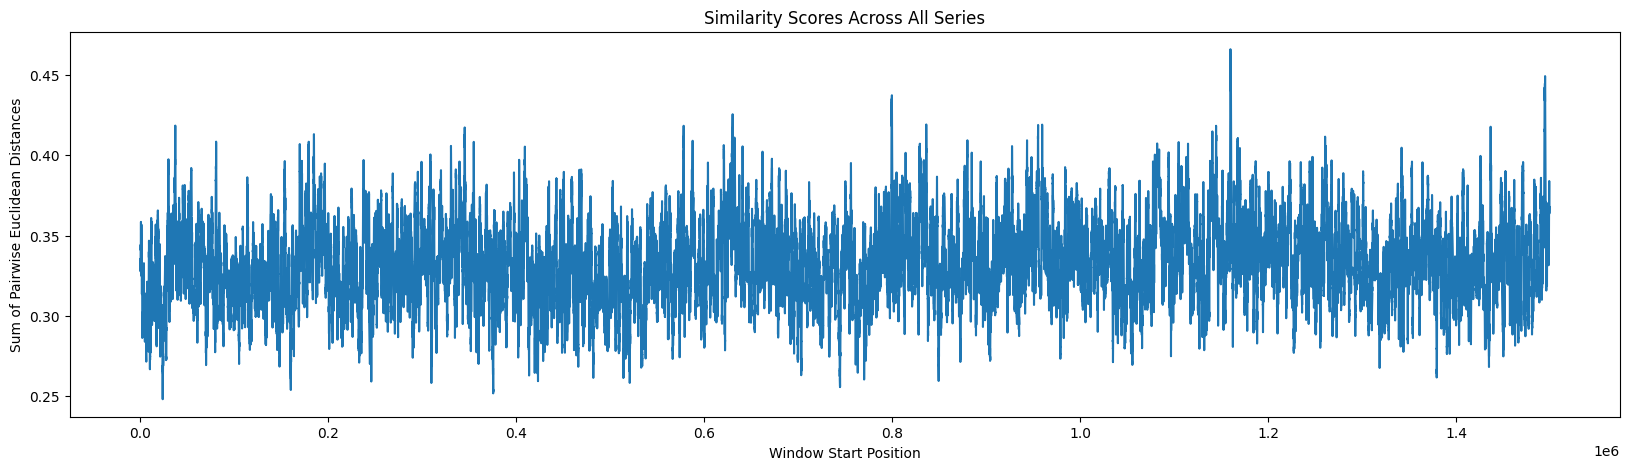

Similar regions (start positions): [   2019    2020    2021 ... 1480582 1480583 1480584]


In [17]:
#### 0-34
#### ['Backscat'][from 0 to 34][i])

# Detrending the data
detrended_data = []
for i in range(5):
    series = pd.Series(loaded_data['Backscat'][0][i])
    series_centered = series - series.mean()
    x = np.arange(len(series_centered))
    p = Polynomial.fit(x, series_centered, 2)
    series_detrended = series_centered - p(x)
    detrended_data.append(series_detrended)

# Convert list to a numpy array for easier manipulation
detrended_data = np.array(detrended_data)

# Define window size
window_size = 1000

# Function to calculate similarity score for a window
def calculate_similarity(window):
    # Compute pairwise Euclidean distances and sum them up
    dist_sum = 0
    for i in range(5):
        for j in range(i + 1, 5):
            dist_sum += euclidean(window[i], window[j])
    return dist_sum

# Sliding window similarity computation
similarity_scores = []
for start in range(len(detrended_data[0]) - window_size + 1):
    window = detrended_data[:, start:start + window_size]
    similarity_score = calculate_similarity(window)
    similarity_scores.append(similarity_score)

# Convert to Pandas series for easier plotting
similarity_scores = pd.Series(similarity_scores)

# Plot the similarity scores
plt.figure(figsize=(20, 5))
plt.plot(similarity_scores)
plt.title('Similarity Scores Across All Series')
plt.xlabel('Window Start Position')
plt.ylabel('Sum of Pairwise Euclidean Distances')
plt.show()

# Find regions with the highest similarity (lowest distance)
threshold = np.percentile(similarity_scores, 5)  # Top 5% most similar
similar_regions = np.where(similarity_scores <= threshold)[0]

print("Similar regions (start positions):", similar_regions)


#### 35-69
#### ['Backscat'][from 35 to 69][i])

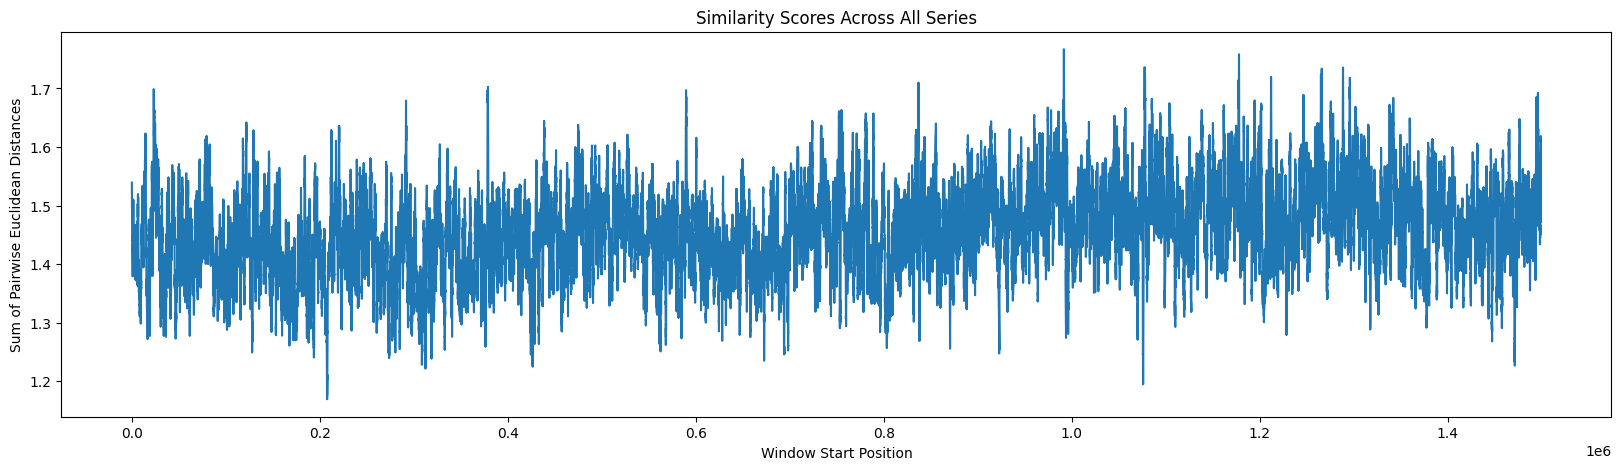

Similar regions (start positions): [   8200    8201    8202 ... 1473513 1473514 1473515]


In [28]:
#### 35-69
#### ['Backscat'][from 35 to 69][i])

# Detrending the data
detrended_data = []
for i in range(10):
    series = pd.Series(loaded_data['Backscat'][35][i])
    series_centered = series - series.mean()
    x = np.arange(len(series_centered))
    p = Polynomial.fit(x, series_centered, 2)
    series_detrended = series_centered - p(x)
    detrended_data.append(series_detrended)

# Convert list to a numpy array for easier manipulation
detrended_data = np.array(detrended_data)

# Define window size
window_size = 1000

# Function to calculate similarity score for a window
def calculate_similarity(window):
    # Compute pairwise Euclidean distances and sum them up
    dist_sum = 0
    for i in range(10):
        for j in range(i + 1, 10):
            dist_sum += euclidean(window[i], window[j])
    return dist_sum

# Sliding window similarity computation
similarity_scores = []
for start in range(len(detrended_data[0]) - window_size + 1):
    window = detrended_data[:, start:start + window_size]
    similarity_score = calculate_similarity(window)
    similarity_scores.append(similarity_score)

# Convert to Pandas series for easier plotting
similarity_scores = pd.Series(similarity_scores)

# Plot the similarity scores
plt.figure(figsize=(20, 5))
plt.plot(similarity_scores)
plt.title('Similarity Scores Across All Series')
plt.xlabel('Window Start Position')
plt.ylabel('Sum of Pairwise Euclidean Distances')
plt.show()

# Find regions with the highest similarity (lowest distance)
threshold = np.percentile(similarity_scores, 5)  # Top 5% most similar
similar_regions = np.where(similarity_scores <= threshold)[0]

print("Similar regions (start positions):", similar_regions)


In [29]:
# Initialize the final DataFrame
final_df = pd.DataFrame()

# Function to detrend the data
def detrend_data(series_list):
    detrended_data = []
    for series in series_list:
        series_centered = series - series.mean()
        x = np.arange(len(series_centered))
        p = Polynomial.fit(x, series_centered, 2)
        series_detrended = series_centered - p(x)
        detrended_data.append(series_detrended)
    return np.array(detrended_data)

# Function to calculate similarity score for a window
def calculate_similarity(window, num_series):
    dist_sum = 0
    for i in range(num_series):
        for j in range(i + 1, num_series):
            dist_sum += euclidean(window[i], window[j])
    return dist_sum

# Function to compute similarity scores
def compute_similarity_scores(detrended_data, window_size, num_series):
    similarity_scores = []
    for start in range(len(detrended_data[0]) - window_size + 1):
        window = detrended_data[:, start:start + window_size]
        similarity_score = calculate_similarity(window, num_series)
        similarity_scores.append(similarity_score)
    return pd.Series(similarity_scores)

# Process data in the range 0-34
for idx in range(35):
    series_list = [pd.Series(loaded_data['Backscat'][idx][i]) for i in range(5)]
    detrended_data = detrend_data(series_list)
    similarity_scores = compute_similarity_scores(detrended_data, window_size=1000, num_series=5)
    final_df = pd.concat([final_df, pd.DataFrame(similarity_scores).T], ignore_index=True)

# Process data in the range 35-69
for idx in range(35, 70):
    series_list = [pd.Series(loaded_data['Backscat'][idx][i]) for i in range(10)]
    detrended_data = detrend_data(series_list)
    similarity_scores = compute_similarity_scores(detrended_data, window_size=1000, num_series=10)
    final_df = pd.concat([final_df, pd.DataFrame(similarity_scores).T], ignore_index=True)


In [31]:
final_df.shape

(70, 1499001)

In [32]:
final_df.to_csv('data/similarity_scores.csv', sep='\t')

### 6. Feature extraction <d id="feature-extraction">

#### Basic Statistical Features

- **Basic Statistical Features**: Capture general distribution characteristics of the signal.
- **FFT Features**: Provide frequency domain information.
- **Autocorrelation Features**: Reflect the repeating patterns or periodicity.
- **Peaks and Troughs**: Highlight significant local maxima and minima.
- **Wavelet Transform Features**: Combine frequency and temporal information.
- **Hurst Exponent**: Indicates long-term memory and trend behavior.
- **Entropy**: Measures complexity or randomness.
- **Zero Crossing Rate**: Indicates the frequency content.
- **Energy**: Represents the power of the signal.
- **Slope Changes**: Capture changes in the direction of the signal.
- **Window-based Features**: Provide localized statistical information.

In [18]:
# Function to extract features
def extract_features(similarity_scores):
    features = {}
    
    # Convert to numpy array if not already
    similarity_scores = np.asarray(similarity_scores)
    
    # Basic statistical features
    features['mean'] = np.mean(similarity_scores)
    features['std'] = np.std(similarity_scores)
    features['min'] = np.min(similarity_scores)
    features['max'] = np.max(similarity_scores)
    features['median'] = np.median(similarity_scores)
    features['skew'] = skew(similarity_scores)
    features['kurtosis'] = kurtosis(similarity_scores)
    
    # FFT features
    fft_vals = fft(similarity_scores)
    features['fft_mean'] = np.mean(np.abs(fft_vals))
    features['fft_std'] = np.std(np.abs(fft_vals))
    
    # Autocorrelation features
    autocorr = acf(similarity_scores, nlags=10)
    for i, val in enumerate(autocorr):
        features[f'autocorr_{i}'] = val
    
    # Peaks and troughs
    peaks, _ = find_peaks(similarity_scores)
    troughs, _ = find_peaks(-similarity_scores)
    features['num_peaks'] = len(peaks)
    features['num_troughs'] = len(troughs)
    features['mean_peak_height'] = np.mean(similarity_scores[peaks]) if len(peaks) > 0 else 0
    features['mean_trough_depth'] = np.mean(similarity_scores[troughs]) if len(troughs) > 0 else 0
    
    # Wavelet transform features
    coeffs = pywt.wavedec(similarity_scores, 'db1', level=3)
    for i, coeff in enumerate(coeffs):
        features[f'wavelet_mean_{i}'] = np.mean(coeff)
        features[f'wavelet_std_{i}'] = np.std(coeff)
    
    # Hurst exponent
    def hurst(ts):
        lags = range(2, 100)
        tau = [np.std(ts[lag:] - ts[:-lag]) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        return poly[0]
    
    features['hurst'] = hurst(similarity_scores)
    
    # Entropy
    def entropy(ts):
        hist, bin_edges = np.histogram(ts, bins=10, density=True)
        hist = hist[hist > 0]
        return -np.sum(hist * np.log(hist))
    
    features['entropy'] = entropy(similarity_scores)
    
    # Zero crossing rate
    zero_crossings = np.where(np.diff(np.sign(similarity_scores)))[0]
    features['zero_crossing_rate'] = len(zero_crossings) / len(similarity_scores)
    
    # Energy
    features['energy'] = np.sum(np.square(similarity_scores))
    
    # Slope changes
    slope_changes = np.diff(np.sign(np.diff(similarity_scores)))
    features['slope_change_count'] = np.sum(slope_changes != 0)
    
    return features


features = extract_features(similarity_scores)
print(features)


{'mean': 0.33407937212622496, 'std': 0.025958219610897233, 'min': 0.24804112304014947, 'max': 0.46613301147432606, 'median': 0.33302270700166914, 'skew': 0.22372172764739037, 'kurtosis': 0.1907956741947161, 'fft_mean': 2.2954610902071035, 'fft_std': 410.25217166228896, 'autocorr_0': 1.0, 'autocorr_1': 0.9999784588705377, 'autocorr_2': 0.9999196566825068, 'autocorr_3': 0.9998249381389225, 'autocorr_4': 0.9996957470478919, 'autocorr_5': 0.9995335581685304, 'autocorr_6': 0.9993398176897909, 'autocorr_7': 0.9991159299737055, 'autocorr_8': 0.9988632656791154, 'autocorr_9': 0.9985831139769938, 'autocorr_10': 0.9982767343361539, 'num_peaks': 116690, 'num_troughs': 116691, 'mean_peak_height': 0.33351635943092106, 'mean_trough_depth': 0.3327009489403356, 'wavelet_mean_0': 0.9449196036786697, 'wavelet_std_0': 0.07341384152558075, 'wavelet_mean_1': -1.5664809608796937e-07, 'wavelet_std_1': 0.0008902735425884349, 'wavelet_mean_2': -4.24884616935062e-08, 'wavelet_std_2': 0.000323590403070331, 'wave

#### Steps to Handle Multiple Reads

In [1]:
df = pd.read_csv('data/similarity_scores.csv', sep = '\t')
# drop df['Unnamed: 0']
df.drop(columns=['Unnamed: 0'], inplace=True)
# transpose the dataframe
df_transposed = df.T

In [8]:
# Testing the script on a single series

# Function to extract features
def extract_features(similarity_scores):
    features = {}
    
    # Convert to numpy array if not already
    similarity_scores = np.asarray(similarity_scores)
    
    # Basic statistical features
    features['mean'] = np.mean(similarity_scores)
    features['std'] = np.std(similarity_scores)
    features['min'] = np.min(similarity_scores)
    features['max'] = np.max(similarity_scores)
    features['median'] = np.median(similarity_scores)
    features['skew'] = skew(similarity_scores)
    features['kurtosis'] = kurtosis(similarity_scores)
    
    # FFT features
    fft_vals = fft(similarity_scores)
    features['fft_mean'] = np.mean(np.abs(fft_vals))
    features['fft_std'] = np.std(np.abs(fft_vals))
    
    # Autocorrelation features
    autocorr = acf(similarity_scores, nlags=10)
    for i, val in enumerate(autocorr):
        features[f'autocorr_{i}'] = val
    
    # Peaks and troughs
    peaks, _ = find_peaks(similarity_scores)
    troughs, _ = find_peaks(-similarity_scores)
    features['num_peaks'] = len(peaks)
    features['num_troughs'] = len(troughs)
    features['mean_peak_height'] = np.mean(similarity_scores[peaks]) if len(peaks) > 0 else 0
    features['mean_trough_depth'] = np.mean(similarity_scores[troughs]) if len(troughs) > 0 else 0
    
    # Wavelet transform features
    coeffs = pywt.wavedec(similarity_scores, 'db1', level=3)
    for i, coeff in enumerate(coeffs):
        features[f'wavelet_mean_{i}'] = np.mean(coeff)
        features[f'wavelet_std_{i}'] = np.std(coeff)
    
    # Hurst exponent
    def hurst(ts):
        lags = range(2, 100)
        tau = [np.std(ts[lag:] - ts[:-lag]) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        return poly[0]
    
    features['hurst'] = hurst(similarity_scores)
    
    # Entropy
    def entropy(ts):
        hist, bin_edges = np.histogram(ts, bins=10, density=True)
        hist = hist[hist > 0]
        return -np.sum(hist * np.log(hist))
    
    features['entropy'] = entropy(similarity_scores)
    
    # Zero crossing rate
    zero_crossings = np.where(np.diff(np.sign(similarity_scores)))[0]
    features['zero_crossing_rate'] = len(zero_crossings) / len(similarity_scores)
    
    # Energy
    features['energy'] = np.sum(np.square(similarity_scores))
    
    # Slope changes
    slope_changes = np.diff(np.sign(np.diff(similarity_scores)))
    features['slope_change_count'] = np.sum(slope_changes != 0)
    
    return features


similarity_scores = df_transposed.iloc[:, 0]

features = extract_features(similarity_scores)
print(features)


{'mean': 0.33407937212622496, 'std': 0.025958219610897233, 'min': 0.2480411230401494, 'max': 0.466133011474326, 'median': 0.3330227070016691, 'skew': 0.22372172764738743, 'kurtosis': 0.19079567419471477, 'fft_mean': 2.295461090207104, 'fft_std': 410.2521716622889, 'autocorr_0': 1.0, 'autocorr_1': 0.9999784588705379, 'autocorr_2': 0.9999196566825068, 'autocorr_3': 0.9998249381389225, 'autocorr_4': 0.9996957470478922, 'autocorr_5': 0.9995335581685304, 'autocorr_6': 0.9993398176897909, 'autocorr_7': 0.9991159299737056, 'autocorr_8': 0.9988632656791154, 'autocorr_9': 0.9985831139769935, 'autocorr_10': 0.9982767343361539, 'num_peaks': 116690, 'num_troughs': 116691, 'mean_peak_height': 0.33351635943092106, 'mean_trough_depth': 0.33270094894033553, 'wavelet_mean_0': 0.9449196036786697, 'wavelet_std_0': 0.07341384152558074, 'wavelet_mean_1': -1.5664809608792341e-07, 'wavelet_std_1': 0.0008902735425884352, 'wavelet_mean_2': -4.248846169343814e-08, 'wavelet_std_2': 0.00032359040307033103, 'wavel

In [9]:
# Performing feature extraction on all columns

# Function to extract features
def extract_features(similarity_scores):
    features = {}

    # Convert to numpy array if not already
    similarity_scores = np.asarray(similarity_scores)

    # Basic statistical features
    features['mean'] = np.mean(similarity_scores)
    features['std'] = np.std(similarity_scores)
    features['min'] = np.min(similarity_scores)
    features['max'] = np.max(similarity_scores)
    features['median'] = np.median(similarity_scores)
    features['skew'] = skew(similarity_scores)
    features['kurtosis'] = kurtosis(similarity_scores)

    # FFT features
    fft_vals = fft(similarity_scores)
    features['fft_mean'] = np.mean(np.abs(fft_vals))
    features['fft_std'] = np.std(np.abs(fft_vals))

    # Autocorrelation features
    autocorr = acf(similarity_scores, nlags=10)
    for i, val in enumerate(autocorr):
        features[f'autocorr_{i}'] = val

    # Peaks and troughs
    peaks, _ = find_peaks(similarity_scores)
    troughs, _ = find_peaks(-similarity_scores)
    features['num_peaks'] = len(peaks)
    features['num_troughs'] = len(troughs)
    features['mean_peak_height'] = np.mean(similarity_scores[peaks]) if len(peaks) > 0 else 0
    features['mean_trough_depth'] = np.mean(similarity_scores[troughs]) if len(troughs) > 0 else 0

    # Wavelet transform features
    coeffs = pywt.wavedec(similarity_scores, 'db1', level=3)
    for i, coeff in enumerate(coeffs):
        features[f'wavelet_mean_{i}'] = np.mean(coeff)
        features[f'wavelet_std_{i}'] = np.std(coeff)

    # Hurst exponent
    def hurst(ts):
        lags = range(2, 100)
        tau = [np.std(ts[lag:] - ts[:-lag]) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        return poly[0]

    features['hurst'] = hurst(similarity_scores)

    # Entropy
    def entropy(ts):
        hist, bin_edges = np.histogram(ts, bins=10, density=True)
        hist = hist[hist > 0]
        return -np.sum(hist * np.log(hist))

    features['entropy'] = entropy(similarity_scores)

    # Zero crossing rate
    zero_crossings = np.where(np.diff(np.sign(similarity_scores)))[0]
    features['zero_crossing_rate'] = len(zero_crossings) / len(similarity_scores)

    # Energy
    features['energy'] = np.sum(np.square(similarity_scores))

    # Slope changes
    slope_changes = np.diff(np.sign(np.diff(similarity_scores)))
    features['slope_change_count'] = np.sum(slope_changes != 0)

    return features

# List to store the features for each column
all_features = []

# Loop through columns 0 to 69
for i in range(70):
    similarity_scores = df_transposed.iloc[:, i]
    features = extract_features(similarity_scores)
    features['column'] = i  # Add column identifier
    all_features.append(features)

# Convert the list of dictionaries to a DataFrame
features_df = pd.DataFrame(all_features)

In [11]:
# drop the columns 'max', 'autocorr_0', 'zero_crossing_rate', 'column'
features_df.drop(['autocorr_0', 'zero_crossing_rate', 'column'], axis=1, inplace=True)
# save the features_df to a csv file
features_df.to_csv('data/features_df.csv', sep='\t', index=False)

### 7. PCA and UMAP <d id="pca-and-umap">

In [7]:
# load the features_df from the csv file
features_df = pd.read_csv('data/features_df.csv', sep='\t')
# Load the csv file
Labels = pd.read_csv('data/Labels.csv', sep='\t')

X = features_df

#### Selecting best normalization method

In [23]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

In [26]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# X_scaled = scaler.fit_transform(X)

In [29]:
# from sklearn.preprocessing import MaxAbsScaler

# scaler = MaxAbsScaler()
# X_scaled = scaler.fit_transform(X)

In [32]:
# from sklearn.preprocessing import Normalizer

# scaler = Normalizer(norm='l2')
# X_scaled = scaler.fit_transform(X)

In [ ]:
# from sklearn.preprocessing import Normalizer

# scaler = Normalizer(norm='l1')
# X_scaled = scaler.fit_transform(X)

In [38]:
# from sklearn.preprocessing import QuantileTransformer

# scaler = QuantileTransformer(output_distribution='normal')
# X_scaled = scaler.fit_transform(X)

/Users/arahjou/Documents/Com_Conda/.conda/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (70). n_quantiles is set to n_samples.
  warnings.warn(


In [41]:
# from sklearn.preprocessing import PowerTransformer

# scaler = PowerTransformer(method='yeo-johnson')  # or method='box-cox' if data is strictly positive
# X_scaled = scaler.fit_transform(X)

In [44]:
# ********************** selected  ************************

# Normalize the features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


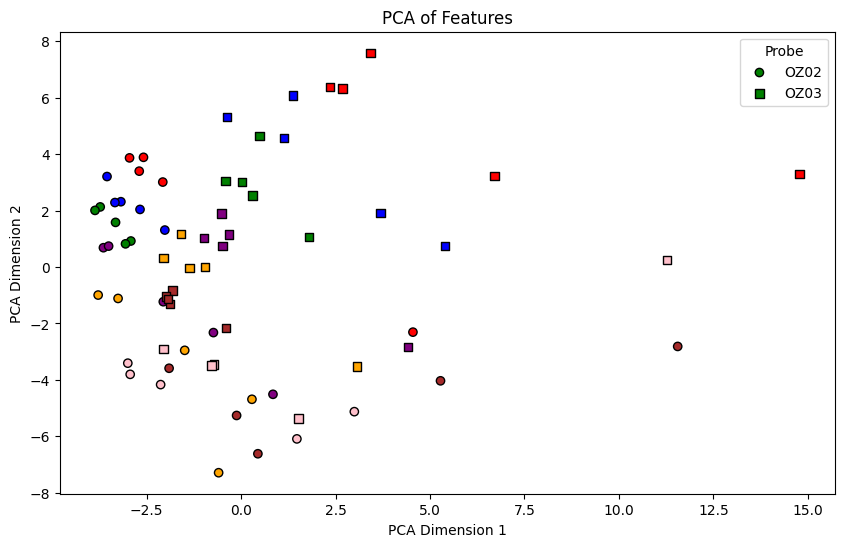

In [45]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Map each label to a color
label_to_color = {
    'C1': 'red', 'C2': 'blue', 'C3': 'green',
    'C4': 'purple', 'C5': 'orange', 'C6': 'brown', 'C7': 'pink'
}
colors = Labels['Label'].map(label_to_color)

# Map each probe to a shape
probe_to_marker = {
    'OZ02': 'o',  # Circle
    'OZ03': 's'   # Square
}
markers = Labels['Probe'].map(probe_to_marker)

# Plot the PCA results
plt.figure(figsize=(10, 6))
for probe in probe_to_marker:
    probe_mask = Labels['Probe'] == probe
    plt.scatter(X_pca[probe_mask, 0], X_pca[probe_mask, 1],
                c=colors[probe_mask], label=probe,
                marker=probe_to_marker[probe], edgecolors='k')

plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('PCA of Features')
plt.legend(title='Probe')
plt.show()


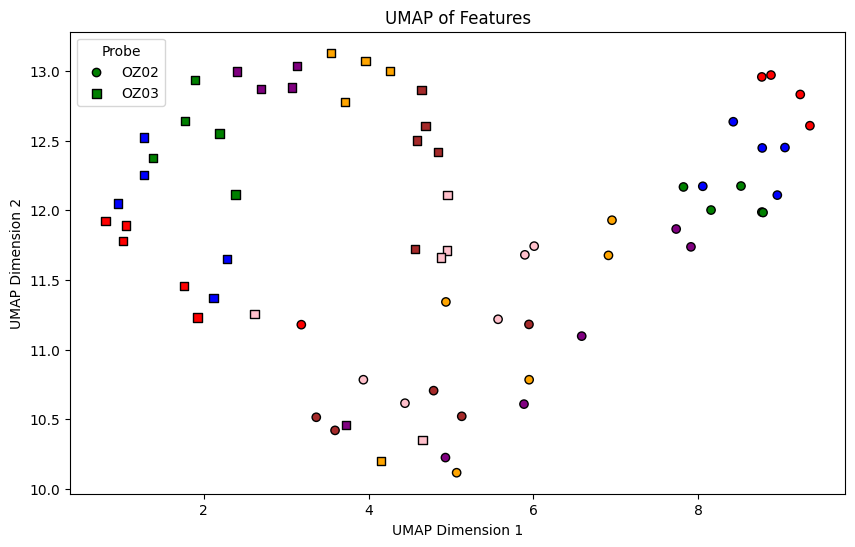

In [46]:
# Perform UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_scaled)

# Map each label to a color
label_to_color = {
    'C1': 'red', 'C2': 'blue', 'C3': 'green',
    'C4': 'purple', 'C5': 'orange', 'C6': 'brown', 'C7': 'pink'
}
colors = Labels['Label'].map(label_to_color)

# Map each probe to a shape
probe_to_marker = {
    'OZ02': 'o',  # Circle
    'OZ03': 's'   # Square
}
markers = Labels['Probe'].map(probe_to_marker)

# Plot the UMAP results
plt.figure(figsize=(10, 6))
for probe in probe_to_marker:
    probe_mask = Labels['Probe'] == probe
    plt.scatter(X_umap[probe_mask, 0], X_umap[probe_mask, 1],
                c=colors[probe_mask], label=probe,
                marker=probe_to_marker[probe], edgecolor='k')

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP of Features')
plt.legend(title='Probe')
plt.show()


### 8. Identifying the most influential features <d id="identifying-the-most-influential-features">

In [52]:
# Separate features and labels
X = features_df
y = Labels['Label']

# Calculate the ANOVA F-value for each feature
f_values, p_values = f_classif(X, y)

# Calculate the mutual information for each feature
mi = mutual_info_classif(X, y)

# Create a DataFrame to hold the scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'ANOVA_F_Value': f_values,
    'Mutual_Information': mi
})

# Normalize the scores
feature_scores['ANOVA_F_Value'] = (feature_scores['ANOVA_F_Value'] - np.min(feature_scores['ANOVA_F_Value'])) / (np.max(feature_scores['ANOVA_F_Value']) - np.min(feature_scores['ANOVA_F_Value']))
feature_scores['Mutual_Information'] = (feature_scores['Mutual_Information'] - np.min(feature_scores['Mutual_Information'])) / (np.max(feature_scores['Mutual_Information']) - np.min(feature_scores['Mutual_Information']))

# Calculate a combined score (you can adjust the weights as needed)
feature_scores['Combined_Score'] = feature_scores['ANOVA_F_Value'] * 0.5 + feature_scores['Mutual_Information'] * 0.5

# Sort the features by the combined score
feature_scores = feature_scores.sort_values(by='Combined_Score', ascending=False)

# Set a threshold for the combined score
threshold = 0.4  # This can be adjusted based on your needs

# Select features that meet the threshold criterion
selected_features = feature_scores[feature_scores['Combined_Score'] >= threshold]

# Display the selected features
print("Selected Features for Further Processing:")
print(selected_features[['Feature', 'Combined_Score']])

# Save the scores to a CSV file
feature_scores.to_csv('feature_importance_scores.csv', index=False)
selected_features.to_csv('selected_features.csv', index=False)


Selected Features for Further Processing:
               Feature  Combined_Score
20         num_troughs        0.898472
34  slope_change_count        0.898471
19           num_peaks        0.898470
2                  min        0.531363
30       wavelet_std_3        0.511764
26       wavelet_std_1        0.507102
28       wavelet_std_2        0.491229


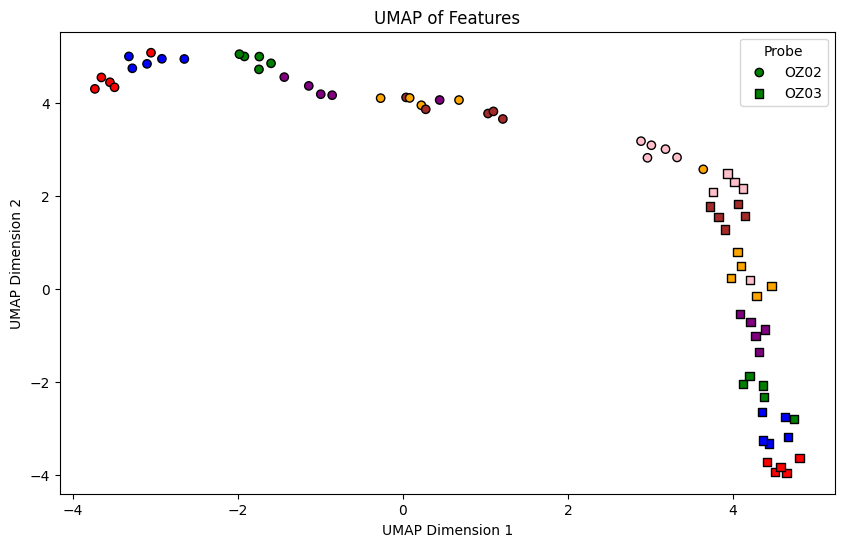

In [55]:
X = features_df[['num_troughs', 'slope_change_count', 'num_peaks', 'min', 'wavelet_std_3', 'wavelet_std_2', 'wavelet_std_1']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_scaled)

# Map each label to a color
label_to_color = {
    'C1': 'red', 'C2': 'blue', 'C3': 'green',
    'C4': 'purple', 'C5': 'orange', 'C6': 'brown', 'C7': 'pink'
}
colors = Labels['Label'].map(label_to_color)

# Map each probe to a shape
probe_to_marker = {
    'OZ02': 'o',  # Circle
    'OZ03': 's'   # Square
}
markers = Labels['Probe'].map(probe_to_marker)

# Plot the UMAP results
plt.figure(figsize=(10, 6))
for probe in probe_to_marker:
    probe_mask = Labels['Probe'] == probe
    plt.scatter(X_umap[probe_mask, 0], X_umap[probe_mask, 1],
                c=colors[probe_mask], label=probe,
                marker=probe_to_marker[probe], edgecolor='k')

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP of Features')
plt.legend(title='Probe')
plt.show()


### 9. Classification model <d id="classification-model">

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best Parameters: {'classification__max_depth': None, 'classification__n_estimators': 100, 'feature_selection__k': 20}
Classification Report:
               precision    recall  f1-score   support

          C1       1.00      0.70      0.82        10
          C2       0.67      0.80      0.73        10
          C3       0.73      0.80      0.76        10
          C4       0.73      0.80      0.76        10
          C5       0.75      0.60      0.67        10
          C6       0.80      0.80      0.80        10
          C7       0.82      0.90      0.86        10

    accuracy                           0.77        70
   macro avg       0.78      0.77      0.77        70
weighted avg       0.78      0.77      0.77        70

Accuracy: 0.7714285714285715
Precision: 0.7841991341991341
Recall: 0.7714285714285715
F1 Score: 0.7712030266652116


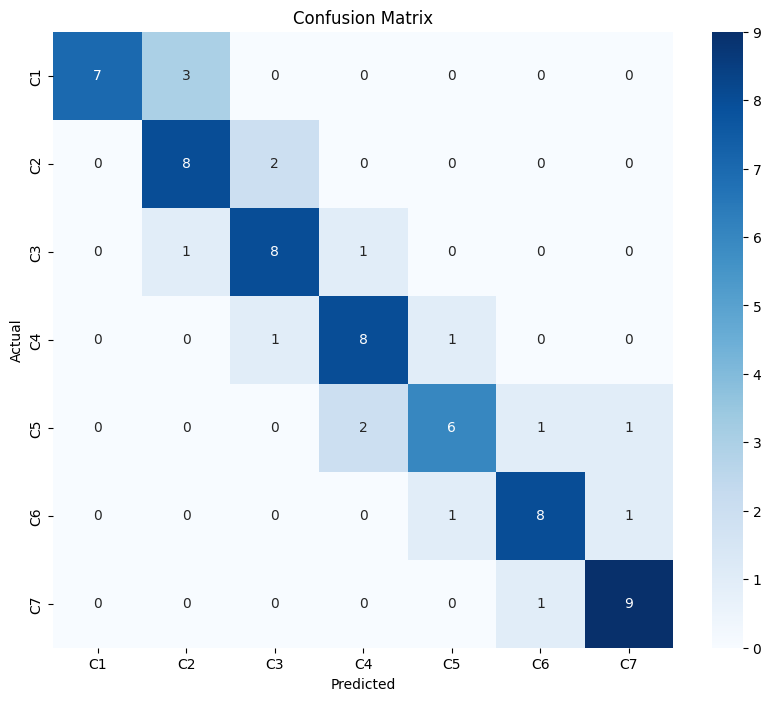

In [57]:
# Separate features and labels
X = features_df
y = Labels['Label']

# Create a pipeline with SelectKBest, StandardScaler, and RandomForestClassifier
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('scaler', StandardScaler()),
    ('classification', RandomForestClassifier(random_state=42))
])

# Set up the parameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': [5, 10, 15, 20, 25, 30, 35],  # number of features to select
    'classification__n_estimators': [50, 100, 150],  # number of trees in the forest
    'classification__max_depth': [None, 10, 20, 30]  # max depth of the tree
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X, y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the model using cross-validation
y_pred = cross_val_predict(best_model, X, y, cv=5)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

print("Classification Report:\n", classification_report(y, y_pred))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Fitting 5 folds for each of 224 candidates, totalling 1120 fits
Best Parameters: {'classification__C': 1, 'classification__gamma': 'scale', 'classification__kernel': 'linear', 'feature_selection__k': 10}
Classification Report:
               precision    recall  f1-score   support

          C1       0.82      0.90      0.86        10
          C2       0.88      0.70      0.78        10
          C3       0.82      0.90      0.86        10
          C4       0.90      0.90      0.90        10
          C5       0.86      0.60      0.71        10
          C6       0.60      0.90      0.72        10
          C7       0.88      0.70      0.78        10

    accuracy                           0.80        70
   macro avg       0.82      0.80      0.80        70
weighted avg       0.82      0.80      0.80        70

Accuracy: 0.8
Precision: 0.8205009276437847
Recall: 0.8
F1 Score: 0.7993890889689208


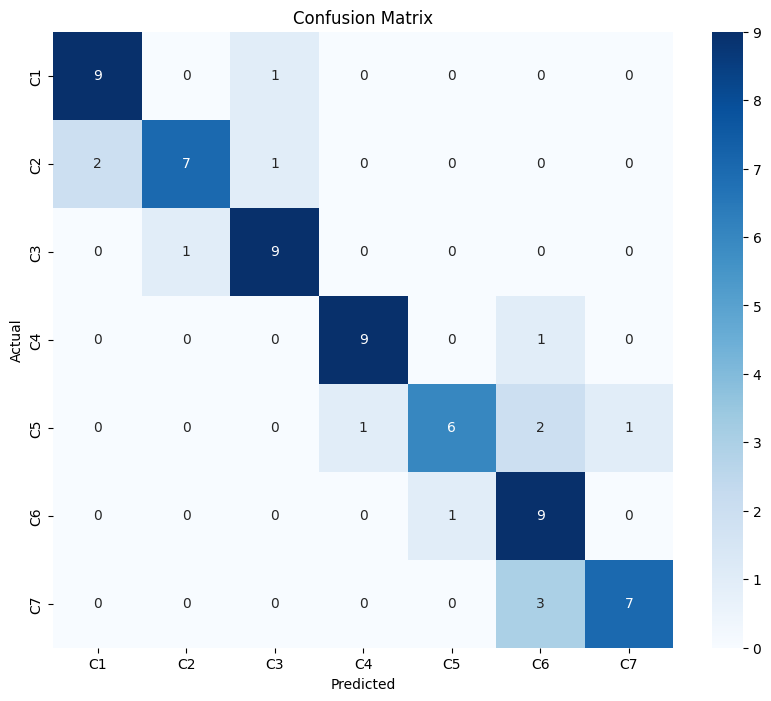

In [58]:
# Separate features and labels
X = features_df
y = Labels['Label']

# Create a pipeline with SelectKBest, StandardScaler, and SVM
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('scaler', StandardScaler()),
    ('classification', SVC(random_state=42))
])

# Set up the parameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': [5, 10, 15, 20, 25, 30, 35],  # number of features to select
    'classification__C': [0.1, 1, 10, 100],  # regularization parameter
    'classification__gamma': ['scale', 'auto'],  # kernel coefficient
    'classification__kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # kernel type
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X, y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the model using cross-validation
y_pred = cross_val_predict(best_model, X, y, cv=5)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

print("Classification Report:\n", classification_report(y, y_pred))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Fitting 5 folds for each of 189 candidates, totalling 945 fits
Best Parameters: {'classification__learning_rate': 0.1, 'classification__max_depth': 3, 'classification__n_estimators': 100, 'feature_selection__k': 10}
Classification Report:
               precision    recall  f1-score   support

          C1       0.90      0.90      0.90        10
          C2       0.75      0.60      0.67        10
          C3       0.69      0.90      0.78        10
          C4       0.80      0.80      0.80        10
          C5       0.89      0.80      0.84        10
          C6       0.89      0.80      0.84        10
          C7       0.82      0.90      0.86        10

    accuracy                           0.81        70
   macro avg       0.82      0.81      0.81        70
weighted avg       0.82      0.81      0.81        70

Accuracy: 0.8142857142857143
Precision: 0.8197524697524697
Recall: 0.8142857142857143
F1 Score: 0.8129469636824981


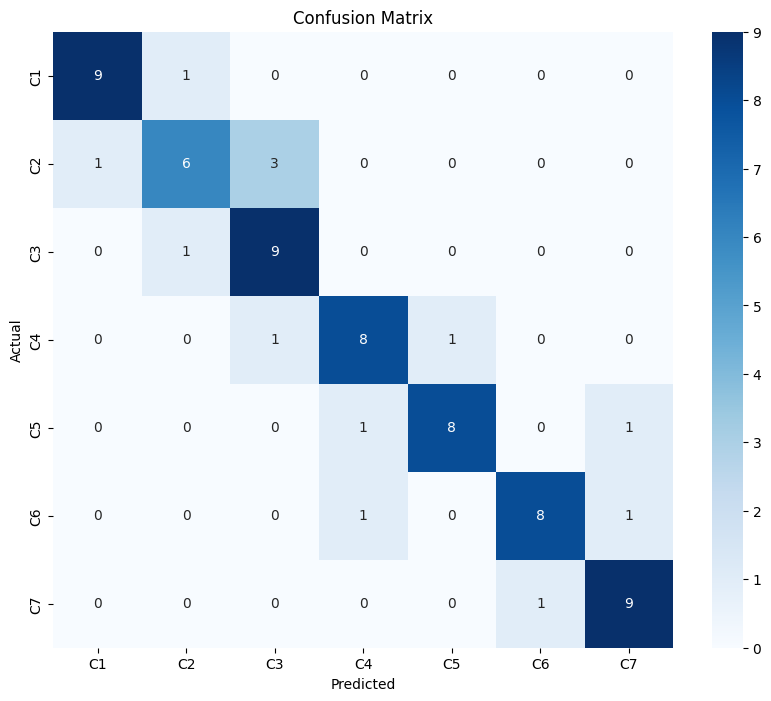

In [59]:
# Separate features and labels
X = features_df
y = Labels['Label']

# Create a pipeline with SelectKBest, StandardScaler, and GradientBoostingClassifier
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('scaler', StandardScaler()),
    ('classification', GradientBoostingClassifier(random_state=42))
])

# Set up the parameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': [5, 10, 15, 20, 25, 30, 35],  # number of features to select
    'classification__n_estimators': [50, 100, 150],  # number of boosting stages
    'classification__learning_rate': [0.01, 0.1, 0.2],  # learning rate
    'classification__max_depth': [3, 4, 5]  # max depth of the individual estimators
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X, y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the model using cross-validation
y_pred = cross_val_predict(best_model, X, y, cv=5)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

print("Classification Report:\n", classification_report(y, y_pred))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


This script creates three separate pipelines for RandomForest, SVM, and GradientBoosting models, each with their own parameter grids. It uses GridSearchCV to find the best parameters for each model, then combines the best estimators into a VotingClassifier using soft voting to aggregate the predicted probabilities. Finally, it fits the ensemble model and evaluates its performance using cross-validation.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Classification Report:
               precision    recall  f1-score   support

          C1       0.90      0.90      0.90        10
          C2       0.78      0.70      0.74        10
          C3       0.75      0.90      0.82        10
          C4       0.80      0.80      0.80        10
          C5       0.89      0.80      0.84        10
          C6       0.80      0.80      0.80        10
          C7       0.80      0.80      0.80        10

    accuracy                           0.81        70
   macro avg       0.82      0.81      0.81        70
weighted avg       0.82      0.81      0.81        70

Accuracy: 0.8142857142857143
Precision: 0.8166666666666668
Recall: 0.8142857142857143
F1 Score: 0.8138755980861244


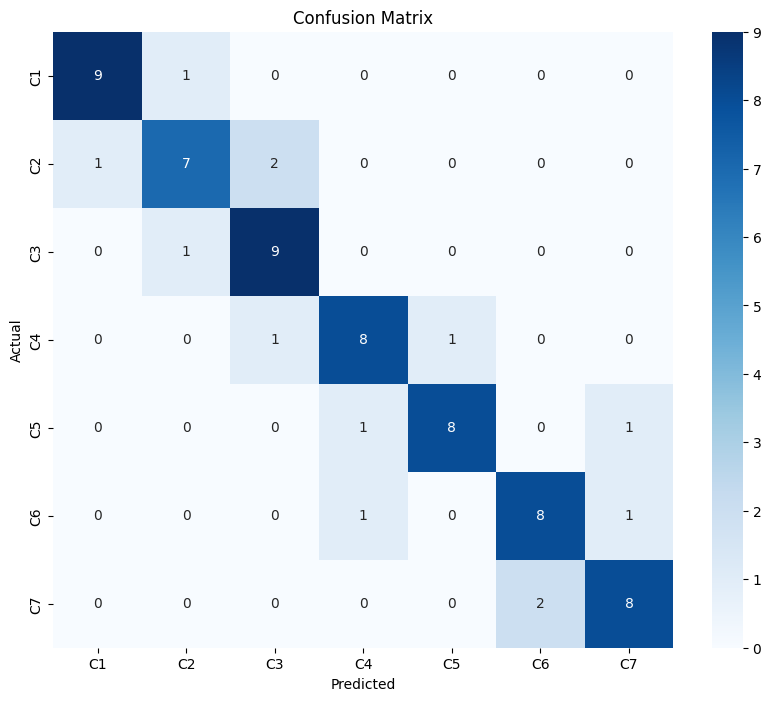

In [67]:
# Separate features and labels
X = features_df
y = Labels['Label']

# Define individual pipelines for each model
rf_pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('scaler', StandardScaler()),
    ('classification', RandomForestClassifier(random_state=42))
])

svm_pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('scaler', StandardScaler()),
    ('classification', SVC(probability=True, random_state=42))
])

gb_pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('scaler', StandardScaler()),
    ('classification', GradientBoostingClassifier(random_state=42))
])

# Set up parameter grids for each pipeline
rf_param_grid = {
    'feature_selection__k': [5, 10, 15],
    'classification__n_estimators': [50, 100],
    'classification__max_depth': [None, 10]
}

svm_param_grid = {
    'feature_selection__k': [5, 10, 15],
    'classification__C': [0.1, 1, 10],
    'classification__gamma': ['scale', 'auto'],
    'classification__kernel': ['linear', 'rbf']
}

gb_param_grid = {
    'feature_selection__k': [5, 10, 15],
    'classification__n_estimators': [50, 100],
    'classification__learning_rate': [0.01, 0.1],
    'classification__max_depth': [3, 4]
}

# Initialize GridSearchCV for each pipeline
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, n_jobs=-1, verbose=1)
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, n_jobs=-1, verbose=1)
gb_grid_search = GridSearchCV(gb_pipeline, gb_param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit each model
rf_grid_search.fit(X, y)
svm_grid_search.fit(X, y)
gb_grid_search.fit(X, y)

# Get the best estimators
best_rf = rf_grid_search.best_estimator_
best_svm = svm_grid_search.best_estimator_
best_gb = gb_grid_search.best_estimator_

# Create a VotingClassifier with the best models
voting_clf = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('svm', best_svm),
    ('gb', best_gb)
], voting='soft')  # Use 'soft' voting to use predicted probabilities

# Fit the VotingClassifier
voting_clf.fit(X, y)

# Evaluate the ensemble model using cross-validation
y_pred = cross_val_predict(voting_clf, X, y, cv=5)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

print("Classification Report:\n", classification_report(y, y_pred))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
